# Introduction
This study explores the dataset made available for the competition<br>
**Hackathon 3.x - Predict customer worth for Happy Customer Bank**<br>
organised by _Analytics Vidhya_ in 2015.<br>

For more information follow the link below:<br>
https://discuss.analyticsvidhya.com/t/hackathon-3-x-predict-customer-worth-for-happy-customer-bank/3802

### **Problem** _(as described in challange)_

''Digital arms of banks today face challenges with lead conversion, they source leads through mediums like search, display, email campaigns and via affiliate partners. Here Happy Customer Bank faces same challenge of low conversion ratio. They have given a problem to identify the customers segments having higher conversion ratio for a specific loan product so that they can specifically target these customers, here they have provided a partial data set for salaried customers only from the last 3 months. They also capture basic details about customers like gender, DOB, existing EMI, employer Name, Loan Amount Required, Monthly Income, City, Interaction data and many others. Let’s look at the process at Happy Customer Bank.''

### **Goal**

Predict the probability of disbursal for test data set.

## Table of Contents

1. **[Data preprocessing](#first-bullet)**
2. **[Modelling](#second-bullet)**

### Importing libraries

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import wikipedia
import re
from bs4 import BeautifulSoup
import seaborn as sns
import pickle
from sklearn.impute import KNNImputer

## Loading the data

In [2]:
FILE = r'Data/Train_nyOWmfK.csv'
data = pd.read_csv(FILE, encoding='latin1')
data.head()

,ID,Gender,City,Monthly_Income,DOB,Lead_Creation_Date,Loan_Amount_Applied,Loan_Tenure_Applied,Existing_EMI,Employer_Name,...,Interest_Rate,Processing_Fee,EMI_Loan_Submitted,Filled_Form,Device_Type,Var2,Source,Var4,LoggedIn,Disbursed
0,ID000002C20,Female,Delhi,20000,23-May-78,15-May-15,300000.0,5.0,0.0,CYBOSOL,...,NaN,NaN,NaN,N,Web-browser,G,S122,1,0,0
1,ID000004E40,Male,Mumbai,35000,07-Oct-85,04-May-15,200000.0,2.0,0.0,TATA CONSULTANCY SERVICES LTD (TCS),...,13.25,NaN,6762.9,N,Web-browser,G,S122,3,0,0
2,ID000007H20,Male,Panchkula,22500,10-Oct-81,19-May-15,600000.0,4.0,0.0,ALCHEMIST HOSPITALS LTD,...,NaN,NaN,NaN,N,Web-browser,B,S143,1,0,0
3,ID000008I30,Male,Saharsa,35000,30-Nov-87,09-May-15,1000000.0,5.0,0.0,BIHAR GOVERNMENT,...,NaN,NaN,NaN,N,Web-browser,B,S143,3,0,0
4,ID000009J40,Male,Bengaluru,100000,17-Feb-84,20-May-15,500000.0,2.0,25000.0,GLOBAL EDGE SOFTWARE,...,NaN,NaN,NaN,N,Web-browser,B,S134,3,1,0


# 1. Data preprocessing <a class="anchor" id="first-bullet"></a>

## Creating dictionaries

### Wikipedia scraping

In [5]:
def wiki_table_scraper(title, table_num=0, header=True):
    wikipedia.set_lang("en")
    page = wikipedia.page(title=title).html()
    soup = BeautifulSoup(page, 'html')
    table = soup.find_all('table', {'class':"wikitable sortable"})[table_num]
    head = False
    if header:
        trs = table.find_all('tr')[1:]
        head = [line.text.strip() for line in table.find_all('tr')[0].find_all('th')]
    else:
        trs = table.find_all('tr')
    
    table_list = [[n.text.strip() for n in line.find_all('td')] for line in trs]
    result = pd.DataFrame(data=table_list, columns=head)
    return result

#### Assigning state to particular city
**1st approach:** _Retrieving information from the Indian population table_

In [6]:
def match_state():
    city_state = wiki_table_scraper('List_of_cities_in_India_by_population')
    city_state.City = city_state.City.apply(lambda x: re.search(r'[\w]+', x).group())
    city_state.iloc[:,4] = city_state.iloc[:,4].apply(lambda x: re.search(r'[\w ]+', x).group())
    state_dict = city_state.set_index(city_state.iloc[:,1]).iloc[:,4].to_dict()
    return state_dict

**2nd approach:** _Search for specific queries_  >>>  _(Filling in the missing information for cities not included in the table.)_

In [7]:
def unmatched(df, match_dict, key):
    non_match = df[~df[key].isin(match_dict.keys())][key].value_counts().index
    return non_match

In [8]:
def match_state_complex(state_names, unmatched, a_sugg=False):    
    matching = {}
    for name in unmatched:
        try:
            page_key = wikipedia.search(f'{name} india')[0]
            page_summary = wikipedia.page(page_key, auto_suggest=a_sugg).summary
            matching[name] = page_summary
        except:
            pass
    match_df = pd.DataFrame.from_dict(matching, orient='index')
    match_df.index
    
    matching_states = {}
    for ix in match_df.index:
        try:
            for word in (match_df.loc[ix, 0]).split():
                if word in state_names:
                    correct_state = word
                    break
            matching_states[ix] = correct_state
        except:
            pass
    return matching_states

#### Assigning GDPs to states

In [9]:
def match_state_GDP():
    gdpS = wiki_table_scraper('List_of_Indian_states_and_union_territories_by_GDP')
    gdpS.iloc[:,2] = gdpS.iloc[:,2].apply(lambda x: re.search(r'\d+.\d+ la', x).group()[:-3]).map(float)
    state_to_gdp = gdpS.set_index(gdpS.iloc[:,1]).iloc[:,2].to_dict()
    return state_to_gdp

#### Assigning population count to cities

In [10]:
def match_population():
    city_table = wiki_table_scraper('List_of_cities_in_India_by_population')
    city_table.City = city_table.City.apply(lambda x: re.search(r'[\w]+', x).group())
    city_table.iloc[:,2] = city_table.iloc[:,2].apply(lambda x: x.replace(',','')).map(int)
    city_pop_dict = city_table.set_index(city_table.iloc[:,1]).iloc[:,2].to_dict()
    return city_pop_dict

In [11]:
def create_dictionaries(dataframe):
#     city_to_state = match_state()
#     states = set(city_to_state.values()) # set of India's states for further use

#     non_matched = unmatched(dataframe, city_to_state, 'City')
#     city_to_state.update(match_state_complex(states, non_matched))
    
    #------------------------------------------------
    # with open('city_to_state.pkl', 'wb') as f:
    #         pickle.dump(city_to_state, f)

    with open('city_to_state.pkl', 'rb') as f:
            city_to_state = pickle.load(f)
    #------------------------------------------------
    states = set(city_to_state.values())
    
    non_matched = unmatched(dataframe, city_to_state, 'City')
    city_to_state.update(match_state_complex(states, non_matched, a_sugg=True))

    states_not_matched = unmatched(dataframe, city_to_state, 'City')
    
    GDP_dict = match_state_GDP()
    city_population = match_population()
    
    # Creating City Rank with first 20 cities sorted by most frequent occurrence in the data
    city_rank_keys = dataframe.City.value_counts()[:20].keys()
    
    gender_dict = {'Female': 1, 'Male': 0}
    
    # Creating Employer Rank with first 15 Employers sorted by most frequent occurrence in the data
    employer_rank_keys = dataframe.Employer_Name.value_counts()[:15].keys()
    
    return city_to_state, GDP_dict, city_population, city_rank_keys, gender_dict, employer_rank_keys, states_not_matched

#### Dates processing

In [12]:
def manage_dates(dataset):
    dataset['DOB'] = pd.to_datetime(dataset['DOB'], format='%d-%b-%y')
    dataset['Lead_Creation_Date'] = pd.to_datetime(dataset['Lead_Creation_Date'], format='%d-%b-%y')
    dataset['Age_at_lead'] =  dataset['Lead_Creation_Date'].dt.year - dataset['DOB'].dt.year
    dataset['Age_at_lead'] = dataset['Age_at_lead'].where(dataset['Age_at_lead'] > 0, dataset['Age_at_lead']+100)
    return dataset

#### Monthly Income
Cutting part of the outliers with substitution to the maximum value _100 000_ (this value is still over upper IQR bound)

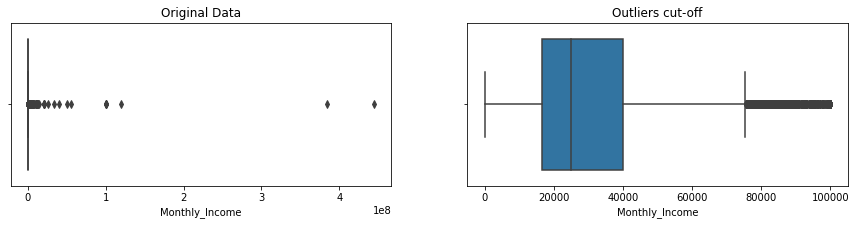

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(15,3))

sns.boxplot(x=data.Monthly_Income, ax=axs[0])
axs[0].title.set_text("Original Data")
sns.boxplot(x=data.Monthly_Income.where(data.Monthly_Income < 100000, other=100000), ax=axs[1])
axs[1].title.set_text("Outliers cut-off")

plt.show()

In [14]:
def data_preprocessing(dataframe):
    # Creating new columns with dictionaries
    dataframe['State'] = dataframe.City.map(to_state)
    dataframe['StateGDP'] = dataframe.State.map(GDPs).map(float)
    dataframe['City_population'] = dataframe.City.map(population)
    dataframe['City_rank'] = dataframe.City.where(dataframe.City.isin(city_rank), other='other')
    dataframe.Gender = dataframe.Gender.map(gender_dict)
    dataframe['Employer_rank'] = data.Employer_Name.where(data.Employer_Name.isin(employer_rank_keys), other='other')
        
    dataframe.Monthly_Income = dataframe.Monthly_Income.where(dataframe.Monthly_Income < 100000, other=100000)
    
    mobile_dict = {'Y': 1, 'N': 0}
    dataframe.Mobile_Verified = dataframe.Mobile_Verified.map(mobile_dict)
    
    # Managing dates
    dataframe = manage_dates(dataframe)
    
    # Imputing missing Interest_Rate and Processing_Fee data with KNN - fully Nan rows are ommited
    for_impute = dataframe[['Loan_Amount_Submitted', 'Loan_Tenure_Submitted', 'Interest_Rate', 'Processing_Fee']].dropna(how='all')
    imputer = KNNImputer(n_neighbors=2)
    imputed = imputer.fit_transform(for_impute)
    dataframe['Interest_Rate_Imputed'] = pd.DataFrame(imputed, index=for_impute.index)[2]
    dataframe['Processing_Fee_Imputed'] = pd.DataFrame(imputed, index=for_impute.index)[3]

    # creating additional columns: EMI calculated and EMI/Income ratios
    EMI_P = dataframe.Loan_Amount_Submitted
    EMI_R = dataframe.Interest_Rate_Imputed/12/100
    EMI_N = dataframe.Loan_Tenure_Submitted*12

    dataframe['EMI_sub_calc'] = (EMI_P * EMI_R * (1 + EMI_R)**EMI_N) / ((1 + EMI_R)**EMI_N - 1)
    dataframe['EMI_Income_tot_ratio'] = (dataframe.Existing_EMI + dataframe.EMI_sub_calc) / dataframe.Monthly_Income
    dataframe['EMI_sub_Income_ratio'] = dataframe.EMI_sub_calc / dataframe.Monthly_Income
    
    # dropping unnecessary columns
    dataframe = dataframe.drop(['ID', 'DOB', 'Lead_Creation_Date', 'City', 'Employer_Name',
                                'Salary_Account', 'Processing_Fee', 'Filled_Form', 'Device_Type',
                                'State','Interest_Rate', 'EMI_Loan_Submitted'], axis=1)
    
    # setting proper category
    cat_list = ['Gender', 'Mobile_Verified', 'Var1', 'Var2', 'Source', 'Var4', 'City_rank', 'Employer_rank']
    dataframe[cat_list] = dataframe[cat_list].astype('category')
    
    return dataframe

In [15]:
to_state, GDPs, population, city_rank, gender_dict, employer_rank_keys, states_not_matched = create_dictionaries(data)

c:\users\antos\appdata\local\programs\python\python38\lib\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file c:\users\antos\appdata\local\programs\python\python38\lib\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


There are a few cities with no state assigned - for the purpose of simplicity they will be ignored in this study:

In [16]:
print(data[data.City.isin(states_not_matched)].City.value_counts())
print('\nMissing', data[data.City.isin(states_not_matched)].City.count(), 'values.')

AHMEDB                  9
Pontashaib              7
Janigir - Champa        7
Proddattur              6
SURENDERNAGAR           4
Kamrup Metropolitian    4
DHANGARDHA              3
Banaskhantha            3
Kabri Anglong           1
Surendra Nagar          1
SOMNATH JUNAGADHA       1
Chinnamiram             1
Name: City, dtype: int64

Missing 47 values.


In [17]:
data_for_modeling = data_preprocessing(data)

In [3]:
# with open('data_for_modeling.pkl', 'wb') as f:
#     pickle.dump(data_for_modeling, f)

with open('data_for_modeling.pkl', 'rb') as f:
    data_for_modeling = pickle.load(f)

In [4]:
data_for_modeling = data_for_modeling.drop(['LoggedIn'], axis=1)

In [5]:
data_for_modeling.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87020 entries, 0 to 87019
Data columns (total 24 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   Gender                  87020 non-null  category
 1   Monthly_Income          87020 non-null  int64   
 2   Loan_Amount_Applied     86949 non-null  float64 
 3   Loan_Tenure_Applied     86949 non-null  float64 
 4   Existing_EMI            86949 non-null  float64 
 5   Mobile_Verified         87020 non-null  category
 6   Var5                    87020 non-null  int64   
 7   Var1                    87020 non-null  category
 8   Loan_Amount_Submitted   52407 non-null  float64 
 9   Loan_Tenure_Submitted   52407 non-null  float64 
 10  Var2                    87020 non-null  category
 11  Source                  87020 non-null  category
 12  Var4                    87020 non-null  category
 13  Disbursed               87020 non-null  category
 14  StateGDP              

Because of significant amount of missing data, **nulls will be assigned (-1)**. _(Lack of data can also carry useful information)_<br>
In such case modeling will be limited to **Tree model types**.

 - You can get by without probability estimates, but if you need them, use calibration (see sklearn.calibration.CalibratedClassifierCV)

UNDERSAMPLING + BAGGING

# 2. Modelling <a class="anchor" id="second-bullet"></a>

In [6]:
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

from sklearn.metrics import roc_auc_score
import scipy.stats as ss

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import MissingIndicator, SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier

from collections import Counter

## Evaluation Cirteria
Evaluation metrics of this challenge was ROC_AUC.

In [7]:
def model_scoring(model,y_tr, X_tr ,y_te, X_te):
    y_pred_train = model.predict_proba(X_tr)[:,1]
    train_score = roc_auc_score(y_tr, y_pred_train)
    y_pred_test = model.predict_proba(X_te)[:,1]
    test_score = roc_auc_score(y_te, y_pred_test)
    cv_scoring = cross_val_score(model, X_train, y_train, scoring='roc_auc', cv=skf, n_jobs=-2)
    print(f'CV score on training set: {cv_scoring.mean().round(4)}')
    print(f'Train ROC_AUC Score: {train_score.round(4)}')
    print(f'Test ROC_AUC Score: {test_score.round(4)}')

## Imbalance Check

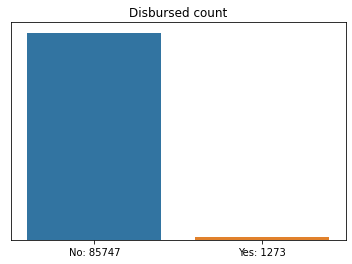

In [8]:
disbursed_count = data_for_modeling.Disbursed.value_counts().values
sns.barplot(x=[0,1], y=disbursed_count)
plt.xticks([0,1], labels=[f'No: {disbursed_count[0]}', f'Yes: {disbursed_count[1]}'])
plt.yticks([])
plt.title('Disbursed count')
plt.show()

**Significant imbalance in data will have to be adressed in modeling phase.**<br>
Stratified K-Folds cross-validator will be used to partially deal with this issue.

In [13]:
skf = RepeatedStratifiedKFold(n_splits=5, n_repeats=2)

## Preparing sets for modelling

In [8]:
X, y = data_for_modeling.drop(["Disbursed"], axis=1), data_for_modeling.Disbursed

num_list = list(X.select_dtypes(exclude='category').columns)
cat_list = list(X.select_dtypes(include='category').columns)

num_pipe = Pipeline([('Imputer', SimpleImputer(strategy='constant', fill_value=-1))])
cat_pipe = Pipeline([('OHE', OneHotEncoder(sparse=False))])
preprocessor = ColumnTransformer(transformers=[('cat', cat_pipe, cat_list),
                                               ('num', num_pipe, num_list)])
X = preprocessor.fit_transform(X)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1, random_state=20, stratify=y)

Due to missing date in set search for the right model was limited to a class of tree models.<br>
## RFC model
First try - _default_ **RFC**:

In [66]:
model = RandomForestClassifier()
model.fit(X_train, y_train)
model_scoring(model, y_train, X_train, y_test, X_test)

CV score on training set: 0.768
Train ROC_AUC Score: 1.0
Test ROC_AUC Score: 0.8079


As expected, default model is overfitting the data.<br>
Limmited samples in leaves should do the trick (as below).

In [67]:
model = RandomForestClassifier(min_samples_leaf=50)
model.fit(X_train, y_train)
model_scoring(model, y_train, X_train, y_test, X_test)

CV score on training set: 0.8346
Train ROC_AUC Score: 0.9161
Test ROC_AUC Score: 0.8613


Significant improvement can already be seen at this point. <br>
Weighted class modelling also increases the score.

In [68]:
model = RandomForestClassifier(min_samples_leaf=50, class_weight='balanced')
model.fit(X_train, y_train)
model_scoring(model, y_train, X_train, y_test, X_test)

CV score on training set: 0.8375
Train ROC_AUC Score: 0.9342
Test ROC_AUC Score: 0.868


### Searching for optimal parameter combination (RFC)

In [106]:
model = RandomForestClassifier(class_weight='balanced')
param_grid = {'n_estimators': [150, 200, 250],
              'min_samples_leaf': [50, 60, 70],
              'max_depth': [5, 8, None]
              }
grid = GridSearchCV(model, param_grid,
                    cv=skf,
                    scoring='roc_auc',
                    n_jobs=-1)

In [107]:
grid.fit(X_train, y_train)

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=5, n_splits=5, random_state=None),
             estimator=RandomForestClassifier(class_weight='balanced'),
             n_jobs=-1,
             param_grid={'max_depth': [5, 8, None],
                         'min_samples_leaf': [50, 60, 70],
                         'n_estimators': [150, 200, 250]},
             scoring='roc_auc')

In [11]:
with open('grid_RFC.pkl', 'rb') as f:
    grid = pickle.load(f)

In [12]:
grid.best_params_

{'max_depth': None, 'min_samples_leaf': 50, 'n_estimators': 200}

In [32]:
best_ix = np.where(grid.cv_results_['rank_test_score']==1)[0]
grid_best_cv = grid.cv_results_['mean_test_score'][best_ix]
print(f'Best grid estimator CV score on training set: {grid_best_cv[0].round(4)}')
model_scoring(grid, y_train, X_train, y_test, X_test)

Best grid estimator CV score on training set: 0.8383
Train ROC_AUC Score: 0.935
Test ROC_AUC Score: 0.8694


### Feature selection

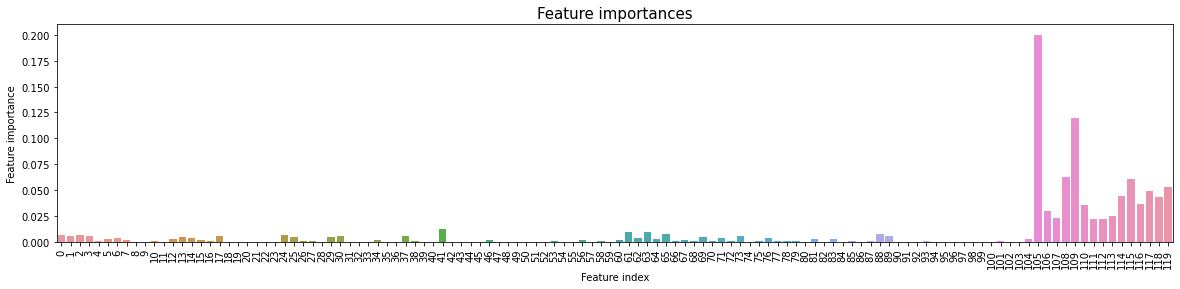

In [39]:
f_imp = grid.best_estimator_.feature_importances_
plt.figure(figsize=(20,4))
sns.barplot(x=[n for n,_ in enumerate(f_imp)], y=f_imp)
plt.xticks(rotation=90)
plt.xlabel('Feature index')
plt.ylabel('Feature importance')
plt.title('Feature importances', fontdict={'fontsize': 15})
plt.show()

Basing on RFC results, number of features could be reduced.<br>
**Removing all features with 0 importance score**

In [40]:
non_zero_ind = np.where(f_imp>0)[0]
X[:,non_zero_ind].shape

(87020, 91)

In [35]:
# with earlier set
model = RandomForestClassifier(n_estimators=250, min_samples_leaf=60, class_weight='balanced')
model.fit(X_train, y_train)
model_scoring(model, y_train, X_train, y_test, X_test)

CV score on training set: 0.8388
Train ROC_AUC Score: 0.9271
Test ROC_AUC Score: 0.8671


In [42]:
X_train_fs, X_test_fs = X_train[:,non_zero_ind], X_test[:,non_zero_ind]

In [44]:
# with feature reduction
model = RandomForestClassifier(n_estimators=250, min_samples_leaf=60, class_weight='balanced')
model.fit(X_train_fs, y_train)
model_scoring(model, y_train, X_train_fs, y_test, X_test_fs)

CV score on training set: 0.8373
Train ROC_AUC Score: 0.9356
Test ROC_AUC Score: 0.8706


In [45]:
# with feature reduction
model = RandomForestClassifier(n_estimators=200, min_samples_leaf=60, class_weight='balanced')
model.fit(X_train_fs, y_train)
model_scoring(model, y_train, X_train_fs, y_test, X_test_fs)

CV score on training set: 0.8385
Train ROC_AUC Score: 0.9354
Test ROC_AUC Score: 0.8692


There is no significant improvement after feature selection for RFC, but feature reduction could potentially improve performance for other types of models.

## XGBoost model

With default settings this model performes quite well - still overfitting the data.

In [46]:
model = XGBClassifier(objective='binary:logistic',
                      use_label_encoder=False)
model.fit(X_train, y_train)
model_scoring(model, y_train, X_train, y_test, X_test)

c:\users\antos\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:55:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CV score on training set: 0.833
Train ROC_AUC Score: 0.9758
Test ROC_AUC Score: 0.8505


With _balancing of positive and negative weights_ model seems to overfit the data, but for more complex settings it will actually enhence the performance.

In [47]:
counter = Counter(y)
scale_weight = np.round(counter[0]/counter[1], 2)
print(scale_weight)

67.36


In [48]:
model = XGBClassifier(objective='binary:logistic', scale_pos_weight=scale_weight,
                      use_label_encoder=False)
model.fit(X_train, y_train)
model_scoring(model, y_train, X_train, y_test, X_test)

[21:56:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CV score on training set: 0.8142
Train ROC_AUC Score: 0.9882
Test ROC_AUC Score: 0.8243


**First 'blind' shot of parameters:**

In [49]:
model = XGBClassifier(n_estimators=150, learning_rate=0.03, max_depth=7,
                      use_label_encoder=False,
                      objective='binary:logistic')
model.fit(X_train, y_train)
model_scoring(model, y_train, X_train, y_test, X_test)

[21:57:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CV score on training set: 0.8395
Train ROC_AUC Score: 0.9098
Test ROC_AUC Score: 0.8538


The same model, but with scale weights - **better preformance**:

In [50]:
model = XGBClassifier(n_estimators=150, learning_rate=0.03, max_depth=7, scale_pos_weight=scale_weight,
                      use_label_encoder=False,
                      objective='binary:logistic')
model.fit(X_train, y_train)
model_scoring(model, y_train, X_train, y_test, X_test)

[21:58:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CV score on training set: 0.8417
Train ROC_AUC Score: 0.9212
Test ROC_AUC Score: 0.8653


Manual correction of parameters:

In [51]:
model = XGBClassifier(n_estimators=180, learning_rate=0.026, max_depth=8, scale_pos_weight=scale_weight,
                      use_label_encoder=False,
                      objective='binary:logistic')
model.fit(X_train, y_train)
model_scoring(model, y_train, X_train, y_test, X_test)

[22:00:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CV score on training set: 0.8443
Train ROC_AUC Score: 0.9415
Test ROC_AUC Score: 0.867


### Searching for optimal parameter combination (XGBoost)

In [104]:
model = XGBClassifier(objective='binary:logistic', scale_pos_weight=scale_weight)
param_grid = {"n_estimators": [180], 
              "learning_rate": ss.uniform(0.01, 0.028),
              "max_depth": ss.randint(7, 9),
              "gamma": ss.uniform(0, 0.05)}

optimizer = RandomizedSearchCV(model, param_grid, 
                               n_iter=100, 
                               cv=skf, 
                               n_jobs=-1,
                               scoring='roc_auc')
optimizer.fit(X_train, y_train)

c:\users\antos\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[02:26:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(cv=RepeatedStratifiedKFold(n_repeats=5, n_splits=5, random_state=None),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_wei...
                                           verbosity=None),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001F7BE456C10>,
                                        '

In [105]:
optimizer.best_params_

{'gamma': 0.04966376744888,
 'learning_rate': 0.03043095178371477,
 'max_depth': 7,
 'n_estimators': 180}

In [10]:
with open('optimizer_xgboost.pkl', 'rb') as f:
    optimizer = pickle.load(f)

In [14]:
model_scoring(optimizer.best_estimator_, y_train, X_train, y_test, X_test)

CV score on training set: 0.8405
Train ROC_AUC Score: 0.9316
Test ROC_AUC Score: 0.8654


Optimized parameters turn out to perform similar to 'blind shot'.<br>

In [238]:
gamma_opt = []
learning_rate_opt = []
max_depth_opt = []
for n in optimizer.cv_results_['params']:
    gamma_opt.append(n['gamma'])
    learning_rate_opt.append(n['learning_rate'])
    max_depth_opt.append(n['max_depth'])

depth_7 = np.where(np.array(max_depth_opt)==7)
depth_8 = np.where(np.array(max_depth_opt)==8)

gamma_opt = np.array(gamma_opt)
learning_rate_opt = np.array(learning_rate_opt)
score_opt = optimizer.cv_results_['mean_test_score']

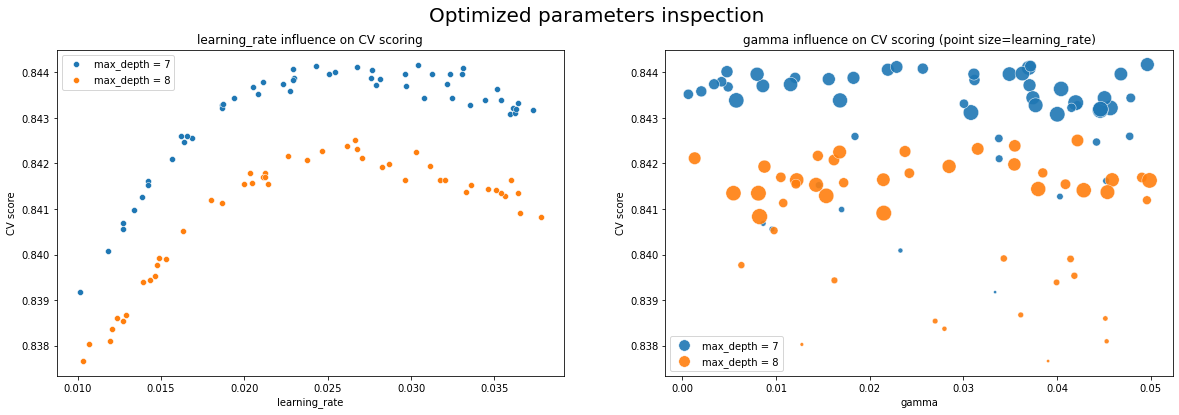

In [250]:
fig, axs = plt.subplots(1, 2, figsize=(20,6))

axs[0] = sns.scatterplot(x=learning_rate_opt[depth_7], y=score_opt[depth_7], ax=axs[0])
axs[0] = sns.scatterplot(x=learning_rate_opt[depth_8], y=score_opt[depth_8], ax=axs[0])
axs[0].legend(['max_depth = 7', 'max_depth = 8'])
axs[0].set_xlabel('learning_rate')
axs[0].set_ylabel('CV score')
axs[0].title.set_text('learning_rate influence on CV scoring')

axs[1] = sns.scatterplot(x=gamma_opt[depth_7], y=score_opt[depth_7], size=learning_rate_opt[depth_7], sizes=(10, 250), alpha=.9, ax=axs[1], legend=False)
axs[1] = sns.scatterplot(x=gamma_opt[depth_8], y=score_opt[depth_8], size=learning_rate_opt[depth_8], sizes=(10, 250), alpha=.9, ax=axs[1], legend=False)
axs[1].legend(['max_depth = 7', 'max_depth = 8'])
axs[1].set_xlabel('gamma')
axs[1].set_ylabel('CV score')
axs[1].title.set_text('gamma influence on CV scoring (point size=learning_rate)')

fig.suptitle('Optimized parameters inspection', fontsize=20) 
plt.show()

Unlike gamma's, learning_rate parameter's influence on performence is very noticable.

# Conclusions
RFC performs really good on this dataset and so do XGBoost. Further optimization of parameters woud be a good path for even better performance, especially for XGBoost. Because of multitude of hyperparameters, another search strategy could be utilized for greater efficiency (possibly Hyperopt optimization would satisfy the needs).

Both models score above 86% roc_auc for test set (for reproducibility with constant split seed).

### TODO:
Reguralization + simplification of models